# Alternative loss function vs MSE

Define function to interpolate for

In [1]:
import torch
from torch import Tensor
def fn_interpolate(x: Tensor):
    return torch.exp(x)

Sample points to work with

In [2]:
N = 5
x = torch.linspace(0, 2, N)
y = fn_interpolate(x)
#######
k = 1
m = 2*k+1

## Work with alternative loss function

Define ''alternative'' loss function

In [3]:
def alternative_loss(A: Tensor, lda: Tensor, f: Tensor) -> Tensor:
    return (1 / 2) * lda.t() @ A @ lda - lda.t() @ f

Create matrix `A` using previous code, as well as vectors `lda`, `f`

In [4]:
input_vector = x.view(-1, 1)
A = torch.abs(input_vector - x) ** m
torch.linalg.cond(A)
A

tensor([[0.0000, 0.1250, 1.0000, 3.3750, 8.0000],
        [0.1250, 0.0000, 0.1250, 1.0000, 3.3750],
        [1.0000, 0.1250, 0.0000, 0.1250, 1.0000],
        [3.3750, 1.0000, 0.1250, 0.0000, 0.1250],
        [8.0000, 3.3750, 1.0000, 0.1250, 0.0000]])

In [5]:
f = y
lda = torch.nn.Parameter(data = torch.randn(N))

# Preemptively calculate solution by matrix inversion
lda_optimum = torch.linalg.solve(A, f)
lda_optimum

tensor([ 2.3375, -3.7985,  1.8910, -3.0573,  1.2378])

Find optimum values for `lda` and store them in `parameters_progress` auxiliary array

In [6]:
max_iterations = 1200

optimizer = torch.optim.Adam(params=[lda], lr=1e-2)
for i in range(max_iterations):
    loss = alternative_loss(A, lda, f)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'{i}: {loss.item()}', end='\r')

(This goes down up until infinity...)

---

**Theorem 107** (Algebra course)

  - $A \in \mathbb{R}^{n \times n}$ spd
  
  - $b \in \mathbb{R}^n$

$\Rightarrow$ The solution of $A x = b$ is the minimizer of
$$ \phi (z) = \frac{1}{2} z^{\top} A z - z^{\top} b. $$

In [45]:
print(A)
torch.linalg.eigvals(A)

tensor([[0.0000, 0.1250, 1.0000, 3.3750, 8.0000],
        [0.1250, 0.0000, 0.1250, 1.0000, 3.3750],
        [1.0000, 0.1250, 0.0000, 0.1250, 1.0000],
        [3.3750, 1.0000, 0.1250, 0.0000, 0.1250],
        [8.0000, 3.3750, 1.0000, 0.1250, 0.0000]])


tensor([ 9.6458+0.j, -9.2762+0.j, -0.7180+0.j,  0.2762+0.j,  0.0722+0.j])

## Work with MSE loss function

In [28]:
import sys
sys.path.insert(0, '../../../modules')

import nn_rbf_phs
import torch

# Use estimation of starting parameters
nn_interpolator = nn_rbf_phs.RBFInterpolant(k=1, centers=x) 

Train model with MSE

In [29]:
max_iterations = 200000
# parameters_progress_mse = torch.zeros(size=(max_iterations, N), requires_grad = False)
parameters_progress_mse = torch.zeros(size=(1, N), requires_grad=False)

# mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=nn_interpolator.parameters(), lr=1e-2)
for i in range(max_iterations):
    loss = torch.sum((nn_interpolator(x) - y) ** 2) / N
    if loss < 1e-13:
        print(f'{i}: {loss.item()}', end='\r')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_progress_mse = torch.cat((parameters_progress_mse, torch.zeros(1, N)))
    parameters_progress_mse[-1, :] = nn_interpolator.coefs    

Print computed parameters vs parameters by matrix inversion

In [46]:
print(nn_interpolator.coefs)
print(lda_optimum)

Parameter containing:
tensor([ 2.3375, -3.7984,  1.8910, -3.0573,  1.2378], requires_grad=True)
tensor([ 2.3375, -3.7985,  1.8910, -3.0573,  1.2378])


/home/higlesias/tfm-experiments/interpolation_comparison/rbf/alternative_functional_GA/../../../modules/nn_rbf_phs.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.nn.Parameter(torch.tensor(coefs))


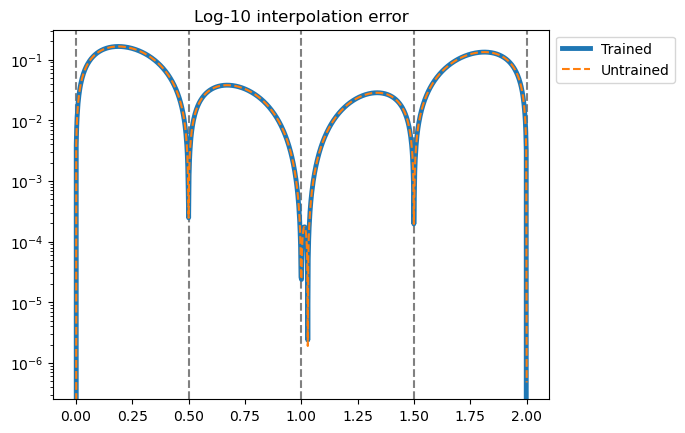

In [74]:
import matplotlib.pyplot as plt

with torch.no_grad():
    nn_interpolator_untrained = nn_rbf_phs.RBFInterpolant(k=1, centers=x, coefs=lda_optimum)
    
    x_verification = torch.linspace(0, 2, 1000)
    y_verification = fn_interpolate(x_verification)
    for vertical in x:
        plt.axvline(vertical, color = "grey", linestyle='--')

    plt.semilogy(x_verification, 
                 torch.abs(nn_interpolator(x_verification) - y_verification), 
                 label="Trained", linewidth='3.5')
    plt.semilogy(x_verification, 
                 torch.abs(nn_interpolator_untrained(x_verification) - y_verification), 
                 label="Untrained", linestyle='--')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Log-10 interpolation error")
    plt.show()

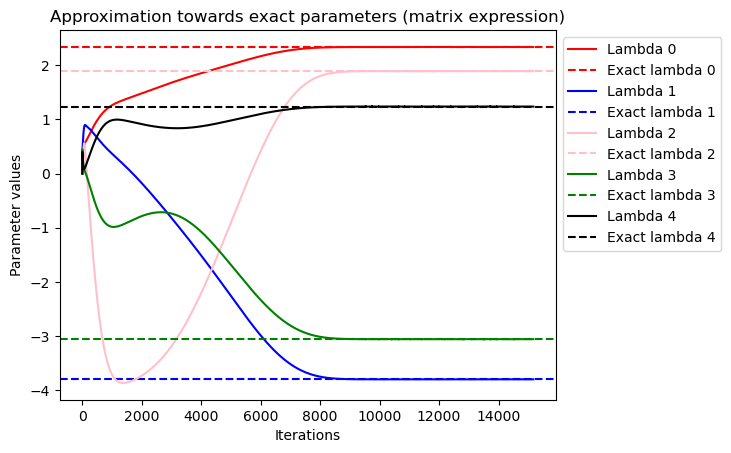

In [70]:
import matplotlib.pyplot as plt

colors = ['red', 'blue', 'pink', 'green', 'black']

for i in range(5):
    plt.plot(parameters_progress_mse[:, i].detach().numpy(), label=f"Lambda {i}", color = colors[i])
    plt.axhline(lda_optimum[i], color = colors[i], linestyle='dashed', label=f'Exact lambda {i}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Parameter values')
plt.xlabel('Iterations')
plt.title('Approximation towards exact parameters (matrix expression)')
plt.show()